In [1]:
import gc
import warnings
import numpy as np
import pandas as pd

import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve,
    roc_auc_score,
    PrecisionRecallDisplay,
    log_loss,
    RocCurveDisplay
)

from intent_model.preprocessing.targets import rh_vs_rest_target

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_parquet('data/rh/dataset_v4/dataset.pq')

In [6]:
len(data)

10525097

In [4]:
data.columns

Index(['valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
       'latitude', 'longitude', 'is_trip_ended', 'service', 'num_trips',
       'quantile', 'trx_amt', 'weekday', 'minutes_sin', 'minutes_cos',
       'is_weekend', 'rh', 'norm_week', 'norm_hour', 'min_dist_to_known_loc',
       'trips_from_or_to_curr_location', 'is_freq', 'dist_to_most_freq',
       'dist_to_second_freq', 'is_home', 'is_work', 'has_saved', 'rh_frac'],
      dtype='object')

In [7]:
data.dtypes

valid_date                                object
ts                                datetime64[ns]
sessionuuid                               object
customer_id                                int64
booking_id                                 int64
latitude                                 float64
longitude                                float64
is_trip_ended                              int64
service                                   object
num_trips                                  int64
quantile                                 float64
trx_amt                                    int64
weekday                                   object
minutes_sin                              float64
minutes_cos                              float64
is_weekend                                 int64
rh                                         int64
norm_week                                float64
norm_hour                                float64
min_dist_to_known_loc                    float64
trips_from_or_to_cur

In [5]:
data.head()

,valid_date,ts,sessionuuid,customer_id,booking_id,latitude,longitude,is_trip_ended,service,num_trips,...,norm_hour,min_dist_to_known_loc,trips_from_or_to_curr_location,is_freq,dist_to_most_freq,dist_to_second_freq,is_home,is_work,has_saved,rh_frac
0,2023-06-27,2023-06-27 04:00:00,FFE53ECB-C04C-442F-9909-BE79185ECFD4,55350252,1775612463,25.23440,55.26050,1,rh,60,...,0.182574,0.067139,59,0,0.067139,4.598149,0,0,1,0.731707
1,2023-06-27,2023-06-27 04:00:00,C111D52E-D41C-4523-B4A9-F435C27630CA,31738098,0,25.04223,55.25033,0,rh,60,...,0.000000,0.041944,6,0,4.114068,13.323311,0,0,1,0.983607
2,2023-06-27,2023-06-27 04:00:00,3F378D1F-621C-482C-8CB0-2FDF87644D4A,18332590,0,25.04376,55.25076,0,rh,79,...,0.000000,6.566052,0,0,7.396961,11.299689,0,0,1,1.000000
3,2023-06-27,2023-06-27 04:00:00,FF06FA4E-737F-4803-ACAF-9EB15CCACBE5,46610104,0,25.01181,55.29931,0,rh,33,...,0.000000,0.037711,27,0,0.037711,2.746468,1,0,1,0.970588
4,2023-06-27,2023-06-27 04:00:01,E5D47F3F-486C-483D-91CB-873F931BF0F0,62066273,0,25.16872,55.40323,0,rh,77,...,0.000000,0.561298,0,0,0.561298,1.036392,0,0,0,1.000000


In [8]:
data = rh_vs_rest_target(data)

In [9]:
data[data.rh == 1].is_freq.value_counts()

0    4444990
1    3207485
Name: is_freq, dtype: int64

In [10]:
TO_DROP = [
    'valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
    'is_trip_ended', 'rh', 'is_freq', 'service', 'has_saved', 'weekday', 'is_work', # 'target'
]

In [11]:
CAT = ['is_home', 'is_weekend']

for col in CAT:
    data[col] = data[col].astype(str)

## Time-based Split

In [12]:
dates = np.sort(data.valid_date.unique())
print(len(dates))

train = data[data.valid_date.isin(dates[:60])].copy()
val = data[data.valid_date.isin(dates[60:75])].copy()
test = data[data.valid_date.isin(dates[75:])].copy()

90


In [13]:
train.target.value_counts()

1    4745949
0    1804466
Name: target, dtype: int64

In [14]:
train['sample_weight'] = 1.0
train.loc[(train.rh == 1) & (train.is_freq == 0), 'sample_weight'] = 0.75
train.loc[(train.rh == 1) & (train.is_trip_ended == 0), 'sample_weight'] = 0.5

In [16]:
train.target.value_counts()

1    4745949
0    1804466
Name: target, dtype: int64

In [17]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train.drop(TO_DROP, axis=1),
    label="target",
    weight="sample_weight",
    batch_size=4096
)

val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    val.drop(TO_DROP, axis=1),
    label="target",
    weight="sample_weight",
    batch_size=4096
)

2023-10-09 12:52:51.928107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-09 12:52:51.928133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [18]:
train.drop(TO_DROP, axis=1).columns

Index(['latitude', 'longitude', 'num_trips', 'quantile', 'trx_amt',
       'minutes_sin', 'minutes_cos', 'is_weekend', 'norm_week', 'norm_hour',
       'min_dist_to_known_loc', 'trips_from_or_to_curr_location',
       'dist_to_most_freq', 'dist_to_second_freq', 'is_home', 'rh_frac',
       'target', 'sample_weight'],
      dtype='object')

In [19]:
train_ds

<_PrefetchDataset element_spec=({'latitude': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'longitude': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'num_trips': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'quantile': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'trx_amt': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'minutes_sin': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'minutes_cos': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'is_weekend': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'norm_week': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'norm_hour': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'min_dist_to_known_loc': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'trips_from_or_to_curr_location': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'dist_to_most_freq': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'dist_to_second_freq': TensorSpec(s

### Model

In [20]:
model = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.builder.Task.CLASSIFICATION,
    num_trees=300,
    max_depth=None,
    max_num_nodes=32,
    growing_strategy='BEST_FIRST_GLOBAL',
    categorical_algorithm='CART',
    subsample=0.9,
    validation_ratio=0.1,
    random_seed=42
)

Use /var/folders/gz/t4xrdmr90n7gd4ht88yqz2mc0000gn/T/tmp3ggw6pl4 as temporary training directory


[WARNING 23-10-09 12:52:58.4925 +04 gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-09 12:52:58.4932 +04 gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-09 12:52:58.4932 +04 gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [21]:
model.fit(train_ds, validation_data=val_ds, verbose=2)

Reading training dataset...
Training tensor examples:
Features: {'latitude': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'longitude': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'num_trips': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'quantile': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'trx_amt': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'minutes_sin': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, 'minutes_cos': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'is_weekend': <tf.Tensor 'data_7:0' shape=(None,) dtype=string>, 'norm_week': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'norm_hour': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'min_dist_to_known_loc': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, 'trips_from_or_to_curr_location': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'dist_to_most_freq': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, 'dist_to_second_freq': <tf.Tensor 'data_13:0' shape=(N

2023-10-09 12:53:00.720258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training dataset read in 0:00:33.690000. Found 6550415 examples.
Reading validation dataset...
Validation tensor examples:
Features: {'latitude': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'longitude': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'num_trips': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'quantile': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'trx_amt': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'minutes_sin': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, 'minutes_cos': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'is_weekend': <tf.Tensor 'data_7:0' shape=(None,) dtype=string>, 'norm_week': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'norm_hour': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'min_dist_to_known_loc': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, 'trips_from_or_to_curr_location': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'dist_to_most_freq': <tf.Tensor 'data_12:0' shape=(None,) d

2023-10-09 12:53:32.601699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Num validation examples: tf.Tensor(1954300, shape=(), dtype=int32)
Validation dataset read in 0:00:09.937963. Found 1954300 examples.
Training model...
Standard output detected as not visible to the user e.g. running in a notebook. Creating a training log redirection. If training gets stuck, try calling tfdf.keras.set_training_logs_redirection(False).

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



[INFO 23-10-09 12:53:42.3775 +04 kernel.cc:773] Start Yggdrasil model training
[INFO 23-10-09 12:53:42.3775 +04 kernel.cc:774] Collect training examples
[INFO 23-10-09 12:53:42.3775 +04 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-10-09 12:53:42.3777 +04 kernel.cc:393] Number of batches: 1600
[INFO 23-10-09 12:53:42.3777 +04 kernel.cc:394] Number of examples: 6550415
[INFO 23-10-09 12:53:43.5669 +04 kernel.cc:794] Training dataset:
Number of records: 6550415
Number of columns: 18

Number of columns by type:
	NUMERICAL: 15 (83.3333%)
	CATEGORICAL: 3 (16.6667%)

Columns:

NUMERICAL: 15 (83.3333%)
	1: "__WEIGHTS" NUMERICAL mean:0.888809 min:0.5

Model trained in 0:20:13.496722
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


2023-10-09 13:13:56.882634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-09 13:13:57.069924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [22]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test.drop(TO_DROP + ['target'], axis=1), batch_size=4096)

In [23]:
ppreds = model.predict(test_ds).flatten()
preds = np.where(ppreds > 0.5, 1, 0)

  7/494 [..............................] - ETA: 9s

2023-10-09 13:14:07.281923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - 9s 17ms/step


### Evaluation

In [24]:
from IPython.core.display import display, HTML
from intent_model.functions import get_optimal_threshold

In [25]:
cb_test_y = test.target.values

In [26]:
log_loss(cb_test_y, ppreds)

0.3849564969525695

In [27]:
roc_auc_score(cb_test_y, ppreds)

0.8725237590469832

In [28]:
print(classification_report(cb_test_y, preds))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66    536095
           1       0.87      0.89      0.88   1484287

    accuracy                           0.83   2020382
   macro avg       0.78      0.77      0.77   2020382
weighted avg       0.82      0.83      0.82   2020382



In [29]:
display(HTML(tfdf.model_plotter.plot_model(model, max_depth=5)))

2023-10-09 13:14:18.936675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [30]:
inspector = model.make_inspector()

inspector.variable_importances()['SUM_SCORE']

[("rh_frac" (1; #15), 1559206.3475629603),
 ("norm_hour" (1; #11), 320820.80142594123),
 ("minutes_sin" (1; #10), 101545.32722162719),
 ("minutes_cos" (1; #9), 99626.7430414507),
 ("dist_to_most_freq" (1; #2), 86716.52773947307),
 ("is_home" (4; #4), 59698.3827437658),
 ("min_dist_to_known_loc" (1; #8), 50122.757518535225),
 ("latitude" (1; #6), 41576.99883407611),
 ("norm_week" (1; #12), 27990.342815591062),
 ("longitude" (1; #7), 24764.524808451242),
 ("dist_to_second_freq" (1; #3), 16783.38427352074),
 ("trips_from_or_to_curr_location" (1; #16), 16098.485711576668),
 ("num_trips" (1; #13), 12845.840329576538),
 ("is_weekend" (4; #5), 11761.49563307416),
 ("quantile" (1; #14), 2933.8315150630606),
 ("trx_amt" (1; #17), 2395.6705646012388)]

In [31]:
target_thresh, expected_recall = get_optimal_threshold(cb_test_y, ppreds, 0.9)

print(target_thresh)
print(expected_recall)

0.6237726
0.8371601988025227


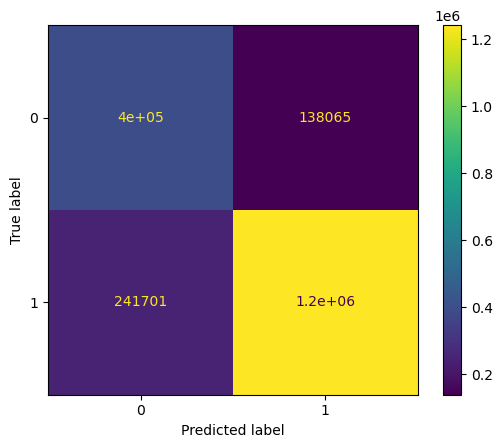

In [32]:
threshold = target_thresh

cm = confusion_matrix(cb_test_y, np.where(ppreds > threshold, 1, 0))
cm_display = ConfusionMatrixDisplay(cm).plot()

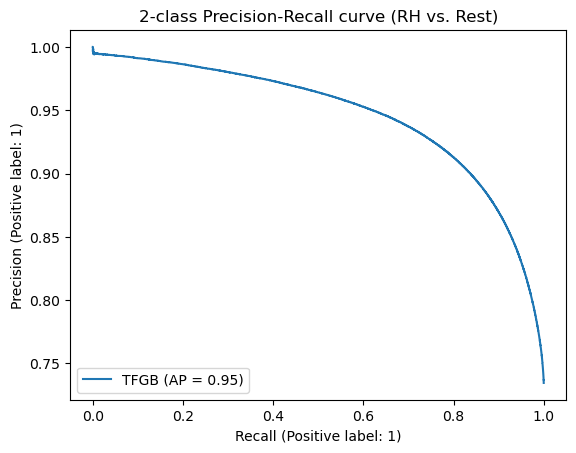

In [33]:
display_ = PrecisionRecallDisplay.from_predictions(cb_test_y, ppreds, name="TFGB")
_ = display_.ax_.set_title("2-class Precision-Recall curve (RH vs. Rest)")

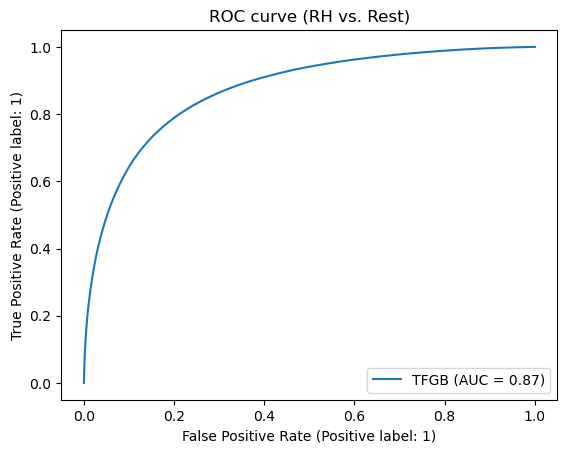

In [34]:
display_ = RocCurveDisplay.from_predictions(cb_test_y, ppreds, name="TFGB")
_ = display_.ax_.set_title("ROC curve (RH vs. Rest)")

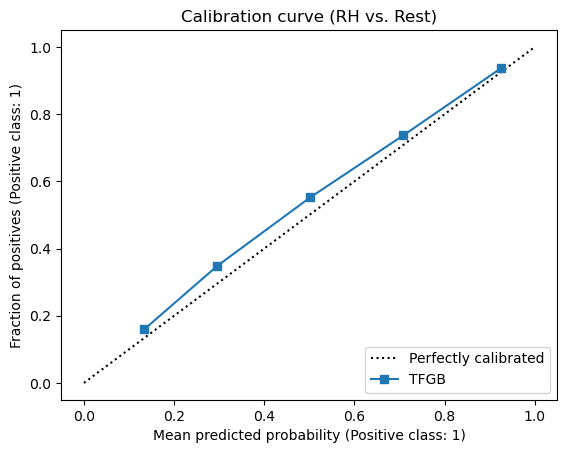

In [35]:
display_ = CalibrationDisplay.from_predictions(cb_test_y, ppreds, name="TFGB")
_ = display_.ax_.set_title("Calibration curve (RH vs. Rest)")

### SHAP

In [36]:
import shap

shap.__version__

'0.42.1'

In [37]:
shap.initjs()

In [38]:
ds_test = test.drop(TO_DROP + ['target'], axis=1)

In [39]:
len(ds_test)

2020382

In [40]:
def f(X: np.ndarray):
    ds = pd.DataFrame(data=X, columns=ds_test.columns)
    ds = tfdf.keras.pd_dataframe_to_tf_dataset(ds)
    return model.predict(ds, verbose=0).flatten()

In [41]:
explainer = shap.KernelExplainer(f, ds_test.iloc[:10], feature_names=ds_test.columns)

2023-10-09 13:14:22.662033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [42]:
shap_values = explainer.shap_values(ds_test.iloc[:1000], nsamples=100, silent=True)

2023-10-09 13:14:22.815416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-09 13:14:22.878530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-09 13:14:22.994071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-10-09 13:14:23.172899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-09 13:14:23.288107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-09 13:14:23.482440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-09 13:14:23.598467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-09 13:14:23.774808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-09 13:14:23.891831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-09 13:14:24.018568: I tensorflow/core/grappler/optimizers/cust

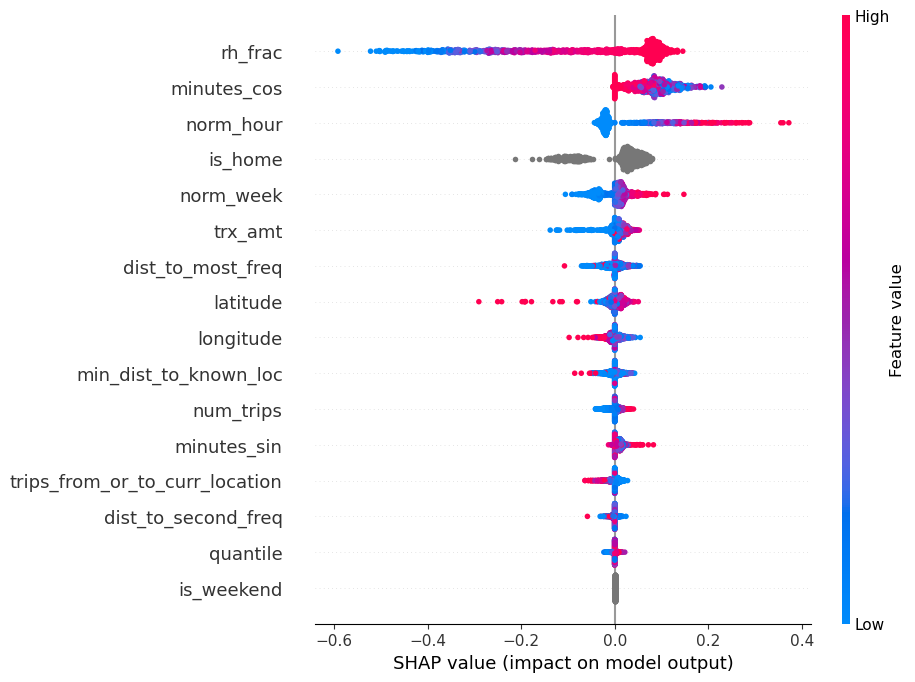

In [48]:
shap.plots.beeswarm(shap.Explanation(shap_values, feature_names=ds_test.columns, data=ds_test.iloc[:1000]), max_display=20)

### Additional Sanity Check

In [44]:
from intent_model.functions import get_relevance

In [45]:
test[test['rh'] == 1]['is_freq'].value_counts()

0    929356
1    554931
Name: is_freq, dtype: int64

In [46]:
res_df = get_relevance(test, test_ds, model, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

res_df

2023-10-09 13:20:01.243551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 13.00it/s]


,threshold,sa_coverage,rh_coverage,relevance (rh total),relevance (freq only),% of freq detected
0,0.3,0.854310,0.956855,0.822839,0.314092,0.976939
1,0.4,0.801265,0.927620,0.850508,0.328309,0.957752
2,0.5,0.750551,0.892804,0.873898,0.341267,0.932543
3,0.6,0.697357,0.849545,0.894985,0.354023,0.898838
4,0.7,0.633957,0.790193,0.915709,0.367996,0.849370
5,0.8,0.552619,0.704343,0.936360,0.384536,0.773673
6,0.9,0.388821,0.509754,0.963154,0.427502,0.605176


In [47]:
gc.collect()

10350

### User Check

In [52]:
c_test = test.copy()
c_test['score'] = ppreds
c_test[(c_test.customer_id == 50794794) & (c_test.target == 1)]

,valid_date,ts,sessionuuid,customer_id,booking_id,latitude,longitude,is_trip_ended,service,num_trips,...,trips_from_or_to_curr_location,is_freq,dist_to_most_freq,dist_to_second_freq,is_home,is_work,has_saved,rh_frac,target,score
6268043,2023-09-10,2023-09-10 09:28:01,f3b50b0a-a7ca-43db-86ee-c83b1b2f70dd,50794794,1811386766,25.09642,55.17618,1,rh,98,...,45,0,2.475769,0.050096,1,0,1,0.560000,1,0.639547
6271933,2023-09-10,2023-09-10 10:31:56,7210940a-fb2d-46ed-8893-9d0c60662298,50794794,1811414348,25.09736,55.16890,1,rh,98,...,0,1,1.851426,0.730771,0,0,1,0.560000,1,0.503561
6275951,2023-09-10,2023-09-10 11:30:21,9d2af96a-099c-4a23-9e5e-0afdc291f6c5,50794794,1811438541,25.09657,55.17674,1,rh,98,...,17,0,2.534497,0.097826,1,0,1,0.560000,1,0.348012
6278700,2023-09-10,2023-09-10 12:05:29,2228a6a3-bb21-482c-91a2-5f592ba7af69,50794794,1811453520,25.04726,55.12255,0,rh,98,...,3,0,5.563067,7.638941,0,0,1,0.560000,1,0.483119
6293434,2023-09-10,2023-09-10 14:52:43,65c82d38-b9ee-46e0-9a30-876c2c6799ea,50794794,1811538833,25.02830,55.10775,1,rh,98,...,0,1,8.144414,10.194545,0,0,1,0.560000,1,0.670250
6355845,2023-09-11,2023-09-11 08:55:39,7a8063f4-281b-4793-be21-39ad8914423e,50794794,1811893055,25.09627,55.17581,1,rh,100,...,49,1,2.435085,0.035601,1,0,1,0.568182,1,0.869969
6429175,2023-09-11,2023-09-11 20:02:39,1c5e02a2-6ea3-427c-8684-86ea6f792c1e,50794794,1812284135,25.08954,55.15309,1,rh,100,...,51,1,0.060726,2.416295,0,0,1,0.568182,1,0.403258
6462576,2023-09-12,2023-09-12 08:58:23,17acddea-4b31-4d0a-8012-ff4af7abc3dc,50794794,1812457822,25.09626,55.17581,1,rh,102,...,51,1,2.434716,0.034668,1,0,1,0.573034,1,0.885551
6534079,2023-09-12,2023-09-12 19:44:17,13b19608-103a-4c8f-ac37-c766edd80ccc,50794794,1812829461,25.08964,55.15314,1,rh,102,...,53,1,0.072548,2.408199,0,0,1,0.573034,1,0.446110
6567522,2023-09-13,2023-09-13 08:41:16,6d6938d5-b4e4-49f0-b3d8-f8170c066449,50794794,1813004436,25.09625,55.17581,1,rh,104,...,53,1,2.434348,0.033747,1,0,1,0.577778,1,0.892031


In [ ]:
ds_test.iloc[0].to_dict()

In [ ]:
c_test[(c_test.score > 0.98) & (c_test.target == 0)]\
    .drop([x for x in TO_DROP if x not in ['customer_id', 'ts']], axis=1)\
    .sort_values('customer_id')

In [ ]:
shap_values = explainer.shap_values(ds_test.loc[6284787,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, ds_test.loc[6284787,:])